In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
MODEL_PATH = "Reactify-model"

In [3]:
import tensorflow as tf
from tensorflow.python.keras.backend import zeros_like

gpus = tf.config.experimental.list_physical_devices("GPU")

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices("GPU")
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import argparse
from functools import reduce
from operator import add
from os import path

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from Reactify.model import model as nn_model
from Reactify.util import register_params, retrieve_kwargs

from Reactify.paper_dataset import (
    FOLDER_PHOTO,
    FOLDER_SIMPLE2R,
    FOLDER_SIMPLE6R,
    df_photo,
    df_simple2r,
    df_simple6r,
    get_reagents,
    min_length,
    photo_dataset,
    photo_numbers,
    photo_reaction_dataset,
    simple2r_reaction_dataset,
    simple6r_reaction_dataset,
    simple_dataset,
    simple_numbers,
)

sns.set(
    context="talk",
    style="ticks",
    font="Arial",
    font_scale=1.0,
    rc={"svg.fonttype": "none", "lines.linewidth": 1.5, "figure.autolayout": True,},
)

1 Physical GPUs, 1 Logical GPUs


In [4]:
def generate_training_dataset(
    augmentation_factor=50,
    leave_out=100,
    max_shift=15,
    max_total_shift=450,
    coeff_wobble=0.1,
    circular_shift=False,
    one_hot=False,
):
    n_examples = augmentation_factor * (
        len(df_photo) + len(df_simple2r) + len(df_simple6r) - leave_out
    )

    inputs = np.zeros((n_examples, 2, min_length), dtype="float32")
    if one_hot:
        outcomes = np.zeros((n_examples, 4), dtype="float32")
    else:
        outcomes = np.zeros(n_examples, dtype="float32")

    val_inputs = np.zeros((leave_out, 2, min_length), dtype="float32")
    if one_hot:
        val_outcomes = np.zeros((leave_out, 4), dtype="float32")
    else:
        val_outcomes = np.zeros(leave_out, dtype="float32")

    cntr = 0

    # generate and augment training data points
    for i in tqdm(range(augmentation_factor), desc="Augmentation"):
        for folder, df, numbers, dataset, rxn_dataset in [
            (
                FOLDER_PHOTO,
                df_photo[:-leave_out],
                photo_numbers,
                photo_dataset,
                photo_reaction_dataset,
            ),
            (
                FOLDER_SIMPLE2R,
                df_simple2r,
                simple_numbers,
                simple_dataset,
                simple2r_reaction_dataset,
            ),
            (
                FOLDER_SIMPLE6R,
                df_simple6r,
                simple_numbers,
                simple_dataset,
                simple6r_reaction_dataset,
            ),
        ]:
            for j, (rxn, label) in df.reset_index(drop=True).iterrows():
                shift = np.random.randint(max_total_shift * 2) - max_total_shift
                if one_hot:
                    outcomes[cntr, label] = 1.0
                else:
                    outcomes[cntr] = label / 3

                inputs[cntr, 0, :] = (
                    reduce(
                        add,
                        [
                            dataset[numbers[r]].shift(
                                np.random.randint(max_shift * 2) - max_shift
                            )
                            * (np.random.randn() * coeff_wobble + 1.0)
                            * coeff
                            for r, coeff in get_reagents(folder, rxn)[0].items()
                            if r in numbers
                        ],
                    )
                    .normalize()
                    .shift(shift, circular=circular_shift)
                    .spectrum.real
                )
                inputs[cntr, 1, :] = (
                    rxn_dataset[j].shift(shift, circular=circular_shift).spectrum.real
                )
                cntr += 1
    cntr = 0

    # generate validation data points
    for folder, df, numbers, dataset, rxn_dataset in [
        (
            FOLDER_PHOTO,
            df_photo[-leave_out:],
            photo_numbers,
            photo_dataset,
            photo_reaction_dataset[-leave_out:],
        )
    ]:
        for j, (rxn, label) in df.reset_index(drop=True).iterrows():
            if one_hot:
                val_outcomes[cntr, label] = 1.0
            else:
                val_outcomes[cntr] = label / 3
            val_inputs[cntr, 0, :] = (
                reduce(
                    add,
                    [
                        dataset[numbers[r]]
                        for r, coeff in get_reagents(folder, rxn)[0].items()
                        if r in numbers
                    ],
                )
                .normalize()
                .spectrum.real
            )
            val_inputs[cntr, 1, :] = rxn_dataset[j].spectrum.real
            cntr += 1

    return inputs, outcomes, val_inputs, val_outcomes

## Read dataset

In [5]:
inputs, outcomes, val_inputs, val_outcomes = generate_training_dataset(leave_out=1018)

Augmentation: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


In [6]:
inputs.shape, outcomes.shape, val_inputs.shape, val_outcomes.shape

((22200, 2, 4876), (22200,), (1018, 2, 4876), (1018,))

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model = nn_model(inputs.shape[-1], dropout_1=0.3, dropout_2=0.3)

In [8]:
def weights(outcomes, nbins=4):
    counts, edges = np.histogram(outcomes, bins=nbins)
    weights = 1 / counts * len(outcomes) / 10
    bins = np.digitize(outcomes, edges) - 1
    bins = np.minimum(bins, nbins - 1)
    return weights[bins]

In [ ]:
model.fit(
    inputs,
    [outcomes, np.zeros_like(outcomes), np.zeros_like(outcomes)],
    epochs=200,
    batch_size=32,
    sample_weight=weights(outcomes),
    validation_data=(val_inputs, [val_outcomes, np.zeros_like(val_outcomes), np.zeros_like(val_outcomes)], weights(val_outcomes)),
    callbacks=[early_stopping],
    verbose=0
)

In [10]:
model.evaluate(x=val_inputs, y=[val_outcomes, np.zeros_like(val_outcomes), np.zeros_like(val_outcomes)], sample_weight=weights(val_outcomes))

32/32 [==============================] - 0s 7ms/step - loss: 0.0405 - model_loss: 0.0396 - model_1_loss: 1.7876e-11 - model_2_loss: 8.5012e-04 - model_mean_absolute_error: 0.2326 - model_1_mean_absolute_error: 2.3332e-06 - model_2_mean_absolute_error: 9.5971e-04


[0.040464866906404495,
 0.03961475193500519,
 1.787556561105852e-11,
 0.0008501167758367956,
 0.23261909186840057,
 2.333209522475954e-06,
 0.000959714176133275]

In [11]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: Reactify-model/assets


## Evaluate model

Load model from `model_path` (if necessary)

In [6]:
model = tf.keras.models.load_model(MODEL_PATH)

### Evaluate on training set

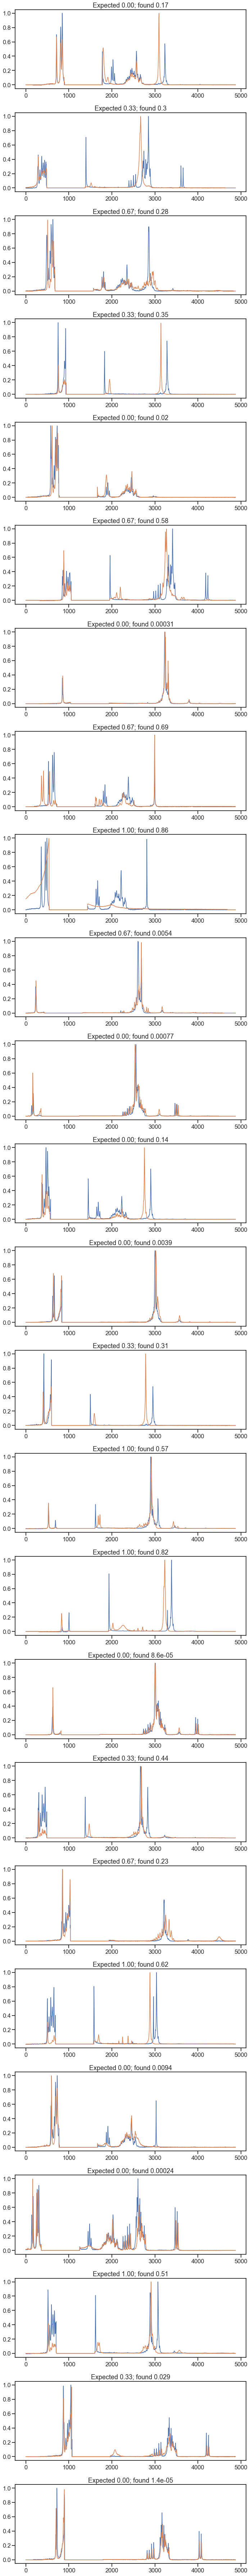

In [12]:
n_plots = 25
out = model(inputs[:n_plots])[0][:, 0]
f, axes = plt.subplots(nrows=n_plots, figsize=(10, 4 * n_plots))
for inp, x, y, ax in zip(inputs, outcomes, out, axes):
    ax.plot(inp.T)
    ax.set_title(f"Expected {x:.2f}; found {y:.2}")
f.savefig("result.svg")

### Evaluate on testing set

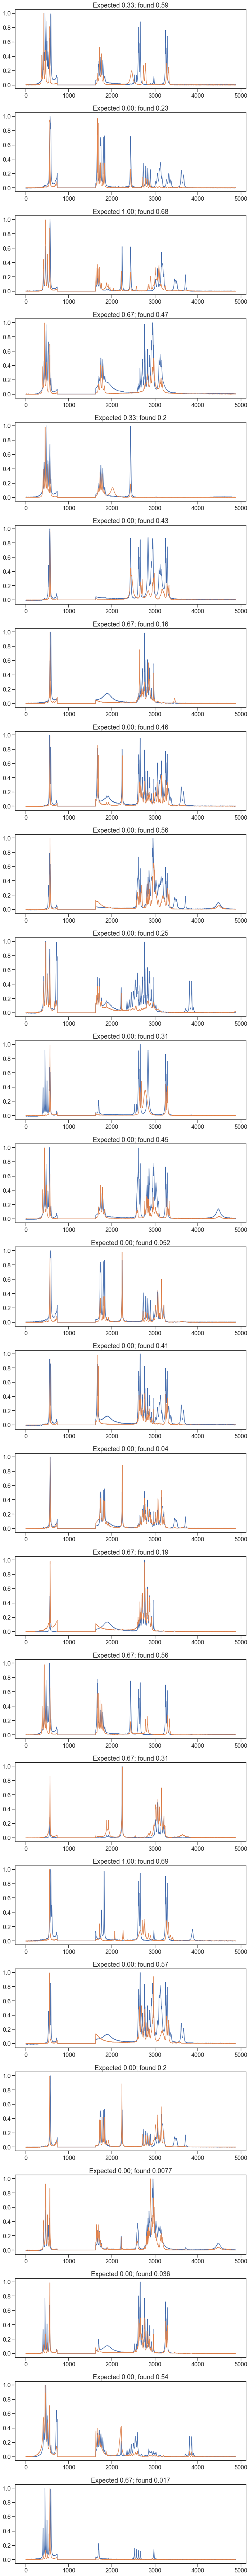

In [13]:
out = model(val_inputs)[0][:, 0]
n_plots = 25
f, axes = plt.subplots(nrows=n_plots, figsize=(10, 4 * n_plots))
for inp, x, y, ax in zip(val_inputs, val_outcomes, out, axes):
    ax.plot(inp.T)
    ax.set_title(f"Expected {x:.2f}; found {y:.2}")
f.savefig("result.svg")

### Confusion matrix

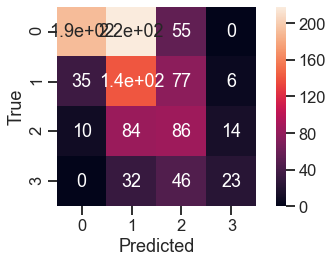

In [14]:
out_classes = np.round(out * 3)
expected_classes = np.round(val_outcomes * 3)
cm = confusion_matrix(expected_classes, out_classes, labels=range(4))
ax = sns.heatmap(cm, square=True, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")